# The Economic Costs of Earthquakes
### DLP

This notebook reproduces the weights from the 2003 paper "The Economic Costs of Conflict: A Case Study of the Basque Country" by Alberto Abadie and Javier Gardeazabal. The study data is contained in the file `../data/basque.csv` (more detailed information on this dataset is available on page 2 of the ``R`` ``synth`` package documentation [here](https://cran.r-project.org/web/packages/Synth/Synth.pdf)).

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

Sectoral shares of GDP: agriculture, administration, construction, education, financial, food, health, information, manufacturing, occupation, professional, public services, rental, retail, transport, wholesale, and others (averaged between 2006 and 2010)


Percentage of the population with a tertiary educational level (averaged between 2007 and 2010)

In [26]:
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest
import sys
sys.path.insert(0, '../src')
import process_chile_gdp_data as pcd

df = pcd.process_data_for_synth()

dataprep = Dataprep(
    foo=df,
    predictors=['agropecuario', 'pesca', 'mineria', 'industria_m',
       'electricidad', 'construccion', 'comercio', 'transporte',
       'servicios_financieros', 'vivienda', 'personales', 'publica'],
    predictors_op="mean",
    time_predictors_prior=range(2005, 2009),
    special_predictors=[
        ("gdp_cap", range(2005, 2009), "mean"),
        ("ed_superior_cap", range(2008, 2009), "mean")
    ],
    dependent="gdp_cap",
    unit_variable="region_name",
    time_variable="year",
    treatment_identifier="VII Del Maule",
    controls_identifier=[
        'I De Tarapacá', 'II De Antofagasta', 'III De Atacama',
       'IV De Coquimbo', 'V De Valparaíso',
       'RMS Región Metropolitana de Santiago',
       'VI Del Libertador General Bernardo OHiggins',
       'IX De La Araucanía', 'X De Los Lagos',
       'XI Aysén del General Carlos Ibáñez del Campo',
       'XII De Magallanes y de la Antártica Chilena'
    ],
    time_optimize_ssr=range(1990, 2009),
)


We supply the `Dataprep` object to a `Synth` object. The optimisation scheme we use is [Nelder-Mead](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html) and the starting point for the optimisation is `equal` i.e. with all weights equal. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point*.

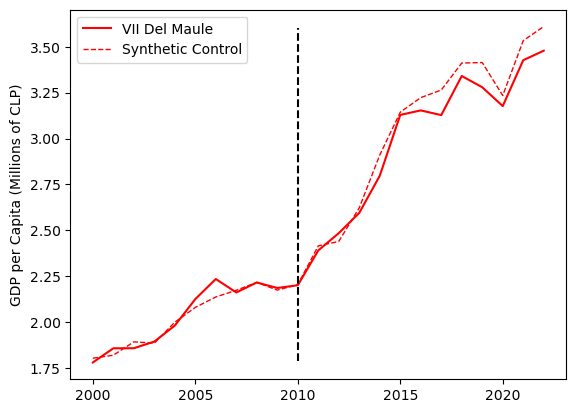

In [33]:
import util
import importlib
from matplotlib import pyplot as plt
importlib.reload(util)

#synth = Synth()
#synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="ols")
cl_res = util.synth_plot_chile(synth, time_period=range(2000, 2023), treatment_time=2010, filename='chile_scm.png')




The synthetic control obtained from the optimisation is: $$\text{Synthetic Control} = 0.851 \times \text{Cataluna} + 0.149 \times \text{Madrid}.$$

The `path_plot` method shows the path of the treated unit and the synthetic control over time.

The `gaps_plot` method shows the gaps (the difference between the treated unit and the synthetic control) over time.

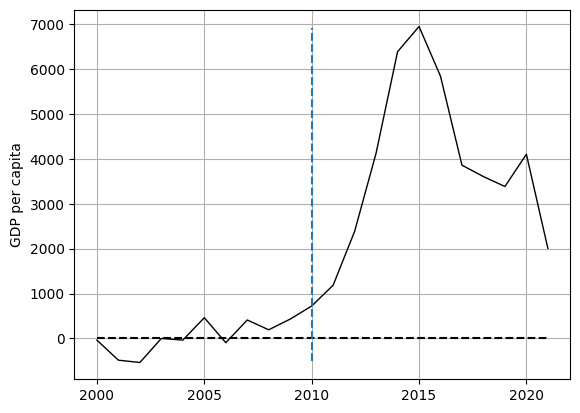

In [52]:
synth.gaps_plot(time_period=range(2000, 2022), treatment_time=2010)

Compute the average treatment effect on the treated unit (ATT) over the post-treatment time period, also returns a standard error (se).

In [55]:
synth.att(time_period=range(2010, 2023))

{'att': 3610.1338439700485, 'se': 533.629047949917}

The summary function gives more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [56]:
synth.summary()

,V,treated,synthetic,sample mean
Agriculture,0.015,0.056,0.066,0.086
Administrative and Support Services,0.002,0.020,0.017,0.015
Construction,0.120,0.055,0.053,0.054
Education and Training,0.024,0.045,0.047,0.043
Financial and Insurance Services,0.064,0.033,0.037,0.029
Food and beverage services,0.093,0.016,0.016,0.014
Health Care and Social Assistance,0.049,0.059,0.054,0.054
"Information Media, Telecommunications and Other Services",0.107,0.068,0.059,0.050
Manufacturing,0.107,0.153,0.146,0.149
"Professional, Scientific, and Technical Services",0.050,0.055,0.054,0.045


We can run a Placebo test using the `PlaceboTest` class. After instantiating it, we supply the original `Dataprep` object to it as well as a synthetic control method object (our `synth` from previously) and any options that we want to supply to the synthetic control method object (the optimisation scheme and starting point for the optimisation scheme).

In [57]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
)

(1/14) Completed placebo test for Auckland.
(2/14) Completed placebo test for Gisborne.
(3/14) Completed placebo test for Manawatu-Whanganui.
(4/14) Completed placebo test for Hawke's Bay.
(5/14) Completed placebo test for Bay of Plenty.
(6/14) Completed placebo test for Marlborough.
(7/14) Completed placebo test for Southland.
(8/14) Completed placebo test for Otago.
(9/14) Completed placebo test for Taranaki.
(10/14) Completed placebo test for Tasman/Nelson.
(11/14) Completed placebo test for Northland.
(12/14) Completed placebo test for Wellington.
(13/14) Completed placebo test for West Coast.
(14/14) Completed placebo test for Waikato.
Calculating treated unit gaps.
Done.


We can plot the gaps for the treated unit as well as all the placebos in one graph using the `gaps_plot` method of the `PlaceboTest` class.

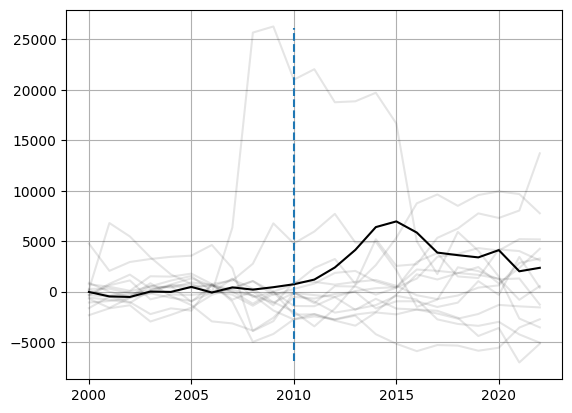

In [59]:
placebo_test.gaps_plot(
    time_period=range(2000, 2023), treatment_time=2010#, exclude_units=["Spain (Espana)"]
)

We can refine the gaps plot by removing those placebos that did not have a good pre-treatment match, namely we can remove from the plot any placebo whose pre-treatment mean-square prediction error is $> n\, \times $ the pre-treatment mean-square prediction error of the treated unit. The following graph is a refined version of the previous with $n=1$ (`mspe_threshold=1`).

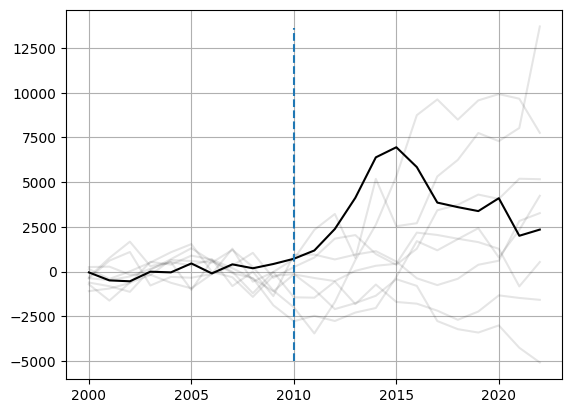

In [61]:
placebo_test.gaps_plot(
    time_period=range(2000, 2023),
    treatment_time=2010,
    #exclude_units=["Spain (Espana)"],
    mspe_threshold=10,
)

We calculate $p$-value of Abadie et al's version of Fisher's exact hypothesis test for no effect of treatment null using the `pvalue` method.

In [62]:
placebo_test.pvalue(treatment_time=2010)

0.0

We can calculate 95% confidence intervals for the treatment effect for the time periods $t=1976, 1977$. (For technical reasons involving permutation tests, we need to use all the pre-intervention time periods here rather than just the period 1960-1970 where the optimisation was carried out if we want a significance level of $\alpha=0.05$).

**(The following cell can take a while to run.)**

In [69]:
synth.confidence_interval(
    alpha=0.20,
    time_periods=[2010, 2011],
    pre_periods=list(range(2000, 2009)),
    tol=0.01,
    verbose=False,
)